In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import time

start_time = time.time() # 計測開始

# Pytorchの組み込み演算により効率的に計算
# 高次元データ用のtorch.arrangeやtorch.expを活用してコードを簡潔に

# 時間埋め込み（正弦波位置エンコーディング）
def pos_encoding(timesteps, output_dim, device='cpu'):
    position = timesteps.view(-1, 1).float()  # 必要に応じて型変換
    div_term = torch.exp(torch.arange(0, output_dim, 2, device=device, dtype=torch.float32) * 
                         (-np.log(10000.0) / output_dim))
    sinusoid = torch.cat([torch.sin(position * div_term), torch.cos(position * div_term)], dim=1)
    return sinusoid

# Dropoutの導入: 過学習を防ぐために、各隠れ層にnn.Dropoutを追加。
# Batch Normalizationの導入: 学習を安定させるためにnn.BatchNorm1dを適用。
# 活性化関数の選択: F.reluの代わりにnn.LeakyReLUやnn.ELUを試すことで、勾配消失問題に対応。

# 拡散モデル
class DiffusionModel(nn.Module):
    def __init__(self, time_embed_dim=16):
        super(DiffusionModel, self).__init__()
        self.time_embed_dim = time_embed_dim  # time_embed_dimをインスタンス変数として初期化
        self.fc1 = nn.Linear(1 + time_embed_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x, t):
        # 時間埋め込み
        t_embed = pos_encoding(t, self.time_embed_dim, x.device)
        x_t = torch.cat([x, t_embed], dim=1)  # 時間情報と入力データを結合
        x_t = F.relu(self.fc1(x_t))
        x_t = F.relu(self.fc2(x_t))
        return self.fc3(x_t)

# 拡散プロセス
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        t_idx = t - 1 # alphas[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)  # (N, 1)
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        
        t_idx = t - 1 # alphas[0] is for t=1
        alpha = self.alphas[t_idx].view(-1, 1)
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)
        model.eval()
        with torch.no_grad():
            eps = model(x, t)

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * eps) / torch.sqrt(alpha)

        return mu

--------------------------------------------------
##################################################
Data_Set_1, Seed: 7270
Train Data Mean: 0.20807583703398852
Train Data Std: 0.9691809069790001
Train Data Shape: (50,)
Epoch 5, Loss: 0.836422398686409
Epoch 10, Loss: 0.8830041766166687
Epoch 15, Loss: 0.3299266457557678
Epoch 20, Loss: 0.2556094527244568
Epoch 25, Loss: 0.2755047556012869
Epoch 30, Loss: 0.23828394636511802
学習終了


学習時間: 108.52秒


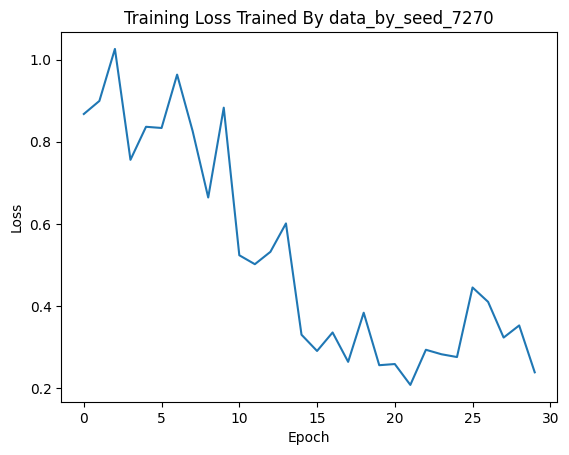



##################################################




In [3]:
####################################################################################################

# ハイパーパラメータ
num_timesteps = 1000 # 拡散ステップ数
epochs = 30          # 学習エポック数
lr = 1e-3            # 学習率
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# シード値の固定
np.random.seed(42)

# サンプリング
iter = 1 #学習元データの数
# シード値の生成
random_seed = np.random.randint(0, 10000, iter)

# モデルとデータを管理する辞書
models = {}
datas = {}

for (i, seed) in enumerate(random_seed):
    print("-"*50)
    print("#"*50)
    print(f"Data_Set_{i+1}, Seed: {seed}")

    # モデルの初期化
    time_embed_dim = 16
    model = DiffusionModel(time_embed_dim=time_embed_dim).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    diffuser = Diffuser(num_timesteps=num_timesteps, device=device)

    # 学習データ(ガウスノイズ)
    np.random.seed(seed)
    data = np.random.randn(50)  # shape: (50,)
    # scaler = StandardScaler()
    # data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    print("Train Data Mean:", data.mean())
    print("Train Data Std:", data.std())
    print("Train Data Shape:", data.shape)
    train_data = torch.tensor(data, dtype=torch.float32).view(-1, 1).to(device)  # shape: (10, 1)

    # データローダー作成
    batch_size = 10
    dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # 学習
    losses = []
    for epoch in range(epochs):
        loss_sum = 0.0
        for batch in dataloader:
            optimizer.zero_grad()
            x = batch.to(device)
            t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

            x_noisy, noise = diffuser.add_noise(x, t)
            noise_pred = model(x_noisy, t)
            loss = F.mse_loss(noise_pred, noise)

            loss.backward()
            optimizer.step()

            loss_sum += loss.item()
        avg_loss = loss_sum / len(dataloader)
        losses.append(avg_loss)
        # 5の倍数エポックで損失を表示
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Loss: {avg_loss}")
    # 辞書に保存
    models[f"model_{i+1}"] = model
    datas[f"seed_{seed}"] = data
    print("学習終了")
    end_time = time.time() # 計測終了
    print('\n')
    print(f"学習時間: {end_time - start_time:.2f}秒")

    # 学習曲線のプロット
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Trained By data_by_seed_{}'.format(seed))
    plt.show()
    print('\n')
    print("#"*50)
    print('\n')

In [ ]:
####################################################################################################

## サンプリング

# 結果の可視化
import matplotlib.pyplot as plt

# # 生成に使用するモデルを選択
# model_key = "model_1"  # 例として "dataset_0" のモデルを使用
# selected_model = models[model_key]  # 辞書からモデルを取得

# 拡散モデルのサンプリング関数
def generate_samples(model, n=50, B=1000, device='cpu'):
    # n: 1データセットあたりのサンプル数
    # B: データセットの数
    model.eval()  # 評価モードに設定
    with torch.no_grad():
        new_sample_list = []
        for _ in range(B):
            torch.manual_seed(np.random.randint(0, 10000)) # シード値の固定
            samples = torch.randn((n, 1), device=device) # デノイズ前の乱数データ
            for t in range(num_timesteps, 0, -1): 
                t_tensor = torch.tensor([t] * len(samples), device=device) # 時刻tのテンソル
                samples = diffuser.denoise(model, samples, t_tensor) # ノイズ除去
            samples = samples.view(n).cpu().numpy() # numpy配列に変換
            new_sample_list.append(samples) # サンプルをリストに追加
    return new_sample_list

generated_data_list = []

for model_key, data, seed, selected_model in zip(datas.keys(), datas.values(), models.keys(), models.values()):
    print("-"*50)
    print("#"*50)
    print(f"Seed: {seed.split('_')[-1]}")
    print("サンプリング開始")

    start_time = time.time() # 計測開始
    generated_data = generate_samples(selected_model, n=50, B=1000, device=device) # サンプリング実行
    generated_data_list.append(generated_data) # サンプルをリストに追加
    end_time = time.time() # 計測終了
    print("サンプリング終了")

    print(f"サンプリング時間: {end_time - start_time:.2f}秒")
    print(f"サンプリング時間: {(end_time - start_time)//60}分 {(end_time - start_time)%60}秒")

    # サンプルされたデータの保存
    torch.save(generated_data, f"master_research/saved_data/sampled_data/sampled_data_{seed.split('_')[-1]}_epoch_{epochs}.pth")
    print("#"*50)

# # 学習済みモデルと学習乱数データの保存と読み込み
# torch.save(models, 'models_dm_epo30.pth')　# モデルの保存
# torch.save(datas, 'sample_datas_dm_epo30.pth')　# 学習乱数データの保存
# models = torch.load('models_dm_epo30.pth')　# モデルの読み込み
# datas = torch.load('sample_datas_dm_epo30.pth') # 学習乱数データの読み込み

# # サンプルされたの保存
# torch.save(datas, 'sample_datas_dm_epo30.pth')　# データの保存
# datas = torch.load('sample_datas_dm_epo30.pth') # データの読み込み

--------------------------------------------------
##################################################
Seed: 1
サンプリング開始
サンプリング終了
サンプリング時間: 704.51秒
サンプリング時間: 11.0分 44.508177280426025秒
##################################################


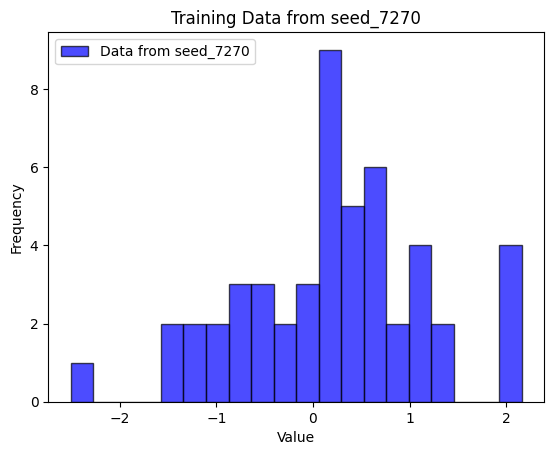

generated_data_mean Shape: (1000,)


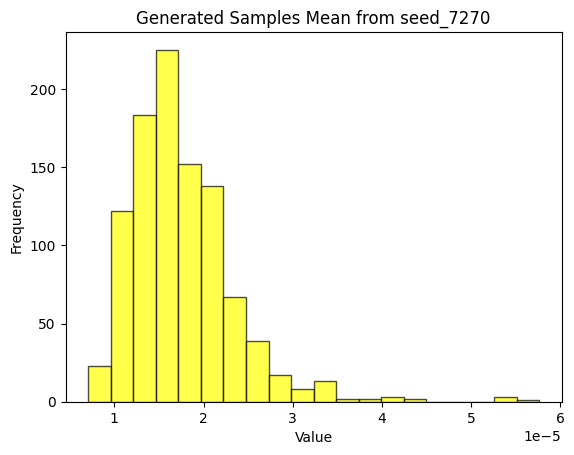

In [5]:
####################################################################################################

## 学習データの可視化
for seed, data in zip(datas.keys(), datas.values()):
    plt.hist(data, bins=20, alpha=0.7, color='blue', edgecolor='black', label=f"Data from seed_{seed.split('_')[-1]}" ) # 学習データのヒストグラムのプロット
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Training Data from seed_{seed.split('_')[-1]}")
    plt.legend()
    plt.show()


## サンプリングデータの可視化
generated_data_var_list = []
# 生成データの＊＊(ある統計量)を求める
# ヒストグラムプロット
for generated_data, seed in zip(generated_data_list, datas.keys()):
    generated_data_mean = np.var(generated_data, axis=1) # 生成データそれぞれ分散を求める
    generated_data_var_list.append(generated_data_mean) # 平均をリストに追加
    print("generated_data_mean Shape:",generated_data_mean.shape) # サイズの確認
    # 平均のヒストグラムのプロット
    plt.hist(generated_data_mean, bins=20, alpha=0.7, color='yellow', edgecolor='black', label=f"Generated from {seed}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title(f"Generated Samples Mean from {seed}")
    plt.show()